In [191]:
import numpy as np
# import pandas as pd
from PIL import Image
import os
import time
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Queremos minimizar la función de pérdida:

$$
\sum_{i=1}^{N} \left( f^*(\mathbf{i}_i) - d_i \right)^2
$$

Es decir, queremos minimizar la diferencia entre los diagnósticos que predice el modelo y los reales. 

Buscamos la mejor solución dentro de las funciones $f : \mathbb{R}^K \to (0, 1)$
 que tengan la forma:

$$
f_{\mathbf{w}, b}(\mathbf{i}) = \frac{\tanh(\mathbf{w} \cdot \mathbf{i} + b) + 1}{2}
$$


donde $w$ es un vector de pesos (weights) de $\mathbb{R}^K$ , $b$ (bias) un escalar, y $tanh$ la tangente hiperbólica.

## Preprocesamiento de imágenes

In [192]:
def image_convert(dir, new_size):
    
    imagenes = []

    for filename in os.listdir(dir):

        file_path = os.path.join(dir, filename)
        # print(f"Procesando imagen {file_path}")
        
        if os.path.isfile(file_path):

            # Sin este if no funciona en mi windows, probar comentarlo en Mac a ver que pasa
            if not filename.lower().endswith('.png'):
                continue

            try:
                with Image.open(file_path) as img:
                    img = img.resize(new_size) 
                    img = img.convert('L') # Convertir a escala de grises
                    img_array = np.array(img)/255.0 # Convertir a array y normalizar
                    img_vector = img_array.reshape((new_size[0]**2)) 
                    imagenes.append(img_vector)

            except Exception as e:
                print(f"Error procesando la imagen {file_path}: {e}")

    return np.array(imagenes)

Convertimos las imágenes a arreglos de pixeles y separamos en train y test

In [193]:
original = (256, 256)
mediano =  (128, 128)
chico = (64, 64)
muy_chico = (32, 32)

size = chico  

En el dataset provisto tenemos 1617 dibujos de pacientes sanos y 1629 dibujos de pacientes con parkinson.

Cómo armamos el conjunto de entrenamiento?
* Tiene que tener cantidades parecidas de pacientes con y sin parkinson.
* Aproximadamente el 70% del total de observaciones deberían ir al conjunto de entrenamiento

Podemos hacerlo asi: \
train \
sanos: 1132 \
enfermos: 1140 

test \
sanos: 485 \
enfermos: 489

In [194]:
# cant_healthy_train = 1132
# cant_park_train = 1140

# cant_healthy_test = 485
# cant_park_test = 489

In [195]:
# Convierto todas las imágenes a arreglos de pixeles según el tamaño elegido

# Healthy
src_dir = 'DatasetTP/Healthy'
i_healthy = image_convert(src_dir, size) # Imágenes de pacientes sanos
d_healthy = np.ones((i_healthy.shape[0], 1)) * 0 # Vector de diagnósticos para la gente sana (0)

# Parkinson
src_dir = 'DatasetTP/Parkinson'  
i_park = image_convert(src_dir, size) # Imágenes de pacientes con Parkinson
d_park = np.ones((i_park.shape[0], 1)) # Vector de diagnósticos para la gente con Parkinson (1)

cant_healthy = i_healthy.shape[0] # Cantidad de imágenes sanas
print(f"Cantidad de imágenes sanas: {cant_healthy}")
cant_park = i_park.shape[0] # Cantidad de imágenes con Parkinson
print(f"Cantidad de imágenes con Parkinson: {cant_park}")

# Separo en train y test

cant_healthy_train = round(cant_healthy * 0.7) # 70% de las imágenes sanas para entrenamiento
cant_healthy_test = cant_healthy - cant_healthy_train # 30% de las imágenes sanas para test

cant_park_train = round(cant_park * 0.7) # 70% de las imágenes con Parkinson para entrenamiento
cant_park_test = cant_park - cant_park_train # 30% de las imágenes con Parkinson para test

print(f"Cantidad de imágenes sanas para entrenamiento: {cant_healthy_train}")
print(f"Cantidad de imágenes sanas para test: {cant_healthy_test}")

i_healthy_train = i_healthy[:cant_healthy_train]
d_healthy_train = d_healthy[:cant_healthy_train]

i_healthy_test = i_healthy[cant_healthy_train:]
d_healthy_test = d_healthy[cant_healthy_train:]

i_park_train = i_park[:cant_park_train]
d_park_train = d_park[:cant_park_train]

i_park_test = i_park[cant_park_train:]
d_park_test = d_park[cant_park_train:]

# Combino sanos y enfermos en train y test
i_train = np.vstack((i_healthy_train, i_park_train)) # Imágenes de entrenamiento
d_train = np.vstack((d_healthy_train, d_park_train)) # Diagnósticos de entrenamiento

i_test = np.vstack((i_healthy_test, i_park_test)) # Imágenes de test
d_test = np.vstack((d_healthy_test, d_park_test)) # Diagnósticos de test

print(i_train.shape, d_train.shape)
print(i_test.shape, d_test.shape)

# Mezclo los datos de entrenamiento y test
np.random.seed(42)  
indices = np.random.permutation(i_train.shape[0])
i_train = i_train[indices]
d_train = d_train[indices]

# Chequeamos que la intersección entre train y test sea nula (Importante)
print(len(set(map(tuple, i_train)).intersection(map(tuple, i_test))) == 0)


Cantidad de imágenes sanas: 816
Cantidad de imágenes con Parkinson: 816
Cantidad de imágenes sanas para entrenamiento: 571
Cantidad de imágenes sanas para test: 245
(1142, 4096) (1142, 1)
(490, 4096) (490, 1)
True


## Derivadas parciales

$$
\arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b) = 
\arg\min_{\mathbf{w}, b} \sum_{i=1}^{N} \left( f_{\mathbf{w}, b}(\mathbf{i}_i) - d_i \right)^2
$$


Derivamos $\mathcal{L}$ con respecto a $b$ (bias) y $w$ (weight):

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial w} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)\cdot i
$$

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial b} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)
$$

In [ ]:
def fwb(i, w, b):
    z = i@w + b 
    f = np.tanh(z) / 2 
    return f 

In [ ]:
# Función a minimizar
def argminL(w, b, i, d):
    return np.sum((fwb(i, w, b) - d) ** 2)

In [ ]:
# Derivada parcial con respecto a w
# def df_w(w, b, i, d):
#     z = i @ w + b 
#     return (1 - np.tanh(z) ** 2) * ((1 + np.tanh(z)) / (2 - d)) @ i # Vector


def df_w(w, b, i, d):
    z = i @ w + b
    y_hat = (np.tanh(z) + 1) / 2
    dz = (1 - np.tanh(z) ** 2) * (y_hat - d)         
    grad_w = i.T @ dz / i.shape[0]                  
    return grad_w

In [199]:
# # Derivada parcial con respecto a b
# def df_b(w, b, i, d):
#     z = i @ w + b
#     y_hat = (np.tanh(z) + 1) / 2
#     dz = (1 - np.tanh(z) ** 2) * (y_hat - d)         
#     grad_w = i.T @ dz                
#     return grad_w
def df_b(w, b, i, d):
    z = i @ w + b
    y_hat = (np.tanh(z) + 1) / 2
    dz = (1 - np.tanh(z) ** 2) * (y_hat - d)
    grad_b = np.sum(dz, axis=0, keepdims=True)  # Da forma (1,1)
    return grad_b

## Gradiente Descendiente

In [200]:
# Máxima cantidad de iteraciones (previene loops infinitos)
MAX_ITER = 1000

# Criterio de convergencia (identifica un "plateau")
TOLERANCIA = 0.01

In [ ]:
MAX_ITER = 1000

TOLERANCIA = 0.01

def gradiente_descendente(b, w, imagenes_train, diagnosticos_train, imagenes_test, diagnosticos_test, alpha=0.1):
    
    iter  = 0
    valores_train = []
    valores_test = []

    while iter <= MAX_ITER:
        print("Iteración: ", iter, "- Mínimo alcanzado hasta el momento: ", argminL(w, b, imagenes_train, diagnosticos_train))

        valores_train.append(argminL(w, b, imagenes_train, diagnosticos_train))

        if imagenes_test is not None and diagnosticos_test is not None: 
          valores_test.append(argminL(w, b, imagenes_test, diagnosticos_test))

        gradiente_w = df_w(w, b, imagenes_train, diagnosticos_train) 
        gradiente_b = df_b(w, b, imagenes_train, diagnosticos_train)
    
        # Si gradiente_b no es escalar, colapsar con promedio o suma
        # if gradiente_b.ndim > 0 and gradiente_b.size > 1:
        #   gradiente_b = np.mean(gradiente_b)  # O np.sum(gradiente_b)

        w_sig = w - alpha * gradiente_w
        b_sig = b - alpha * gradiente_b

        criterio = np.abs(argminL(w_sig, b_sig, imagenes_train, diagnosticos_train) - argminL(w, b, imagenes_train, diagnosticos_train))

        if criterio < TOLERANCIA: # Converge
          break

        w = w_sig
        b = b_sig
        iter += 1

    return w_sig, b_sig, valores_train, valores_test

Iteración:  0 - Mínimo alcanzado hasta el momento:  571.0
Iteración:  1 - Mínimo alcanzado hasta el momento:  589.513226664735
Iteración:  2 - Mínimo alcanzado hasta el momento:  354.43118288553336
Iteración:  3 - Mínimo alcanzado hasta el momento:  1427.4953218467958


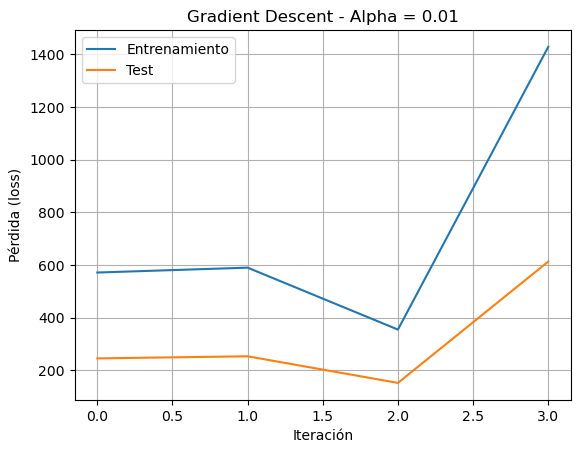

In [202]:
w, b, valores_train, valores_test = gradiente_descendente(
    b=np.zeros((1, 1)), 
    w=np.zeros((i_train.shape[1], 1)), 
    imagenes_train=i_train, 
    diagnosticos_train=d_train, 
    imagenes_test=i_test, 
    diagnosticos_test=d_test, 
    alpha=0.01
)

plt.plot(valores_train, label="Entrenamiento")
plt.plot(valores_test, label="Test")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Gradient Descent - Alpha = 0.01")
plt.legend()
plt.grid(True)
plt.show()

Iteración:  0 - Mínimo alcanzado hasta el momento:  571.0
Iteración:  1 - Mínimo alcanzado hasta el momento:  587.6362132038628
Iteración:  2 - Mínimo alcanzado hasta el momento:  381.0968815667831
Iteración:  3 - Mínimo alcanzado hasta el momento:  1427.4601114197276


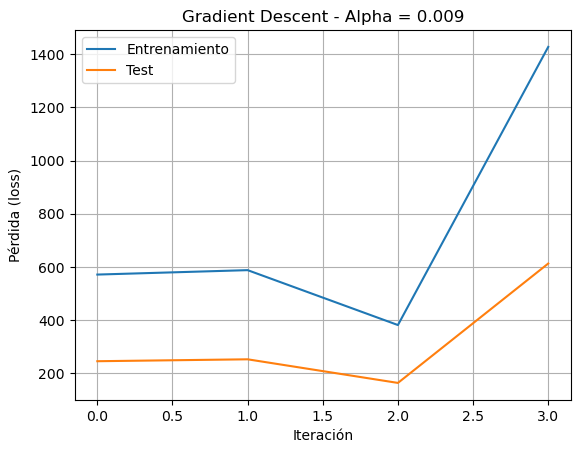

In [203]:
w, b, valores_train, valores_test = gradiente_descendente(
    b=np.zeros((1, 1)), 
    w=np.zeros((i_train.shape[1], 1)), 
    imagenes_train=i_train, 
    diagnosticos_train=d_train, 
    imagenes_test=i_test, 
    diagnosticos_test=d_test, 
    alpha=0.009
)

plt.plot(valores_train, label="Entrenamiento")
plt.plot(valores_test, label="Test")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Gradient Descent - Alpha = 0.009")
plt.legend()
plt.grid(True)
plt.show()